# Movie Success Prediction - What can data tell us about the "magic formula" for box office success?

A movie's box office and critical success, like that of any creative endeavor, is a combination of a huge number of tangible and intangible elements. The onscreen chemistry of the main characters, the director's vision and execution, production values and special effects, the movie's release timing, are just a few of the components that can turn low- or no-budget indy flicks into huge blockbusters or doom an expensively produced studio production to crater at the box office. 

Even sequels that aim to extend the success recipe of their preceding installments aren't 'flop proof.' 
Since the stakes are often high, studio bosses, movie producers and many others in the film industry have been looking for a surefire way to turn their investment into big box office returns since the earliest days of the industry. 

## Problem statement: Is there a "formula for movie success?"
Can past movie releases provide us any kind of 'formula' to increase our chance of commercial success? Are there 'winning combinations' of actors, topics, directors and genres? This project will explore a database of 4,800 movies to first create a visual and quantitative intuition for potential patterns present in movie data and will then attempt to create a predictive algorithm to score 'new movie ideas' that follow a highly structured input format to predict their anticipated revenue. 

## Data source
For this Udacity Data Science Nanodegree Capstone project I will use [The Movie Database](https://www.kaggle.com/tmdb/tmdb-movie-metadata) provided by Kaggle that contains information about 4,800 unique movies including cast, crew, budget, revenue, etc. 

## Metrics: Predicting movie revenue

I will attempt to predict the revenue for a movie idea based on select input variables like cast, budget, genre, keywords, description, etc. 
To evaluate the model accuracy I will use the r2 metric as well as the RMSLE that are often used in regression models. 

- The [r2_score function](https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score) computes the coefficient of determination, usually denoted as R². It represents the proportion of variance (of y) that has been explained by the independent variables in the model. It provides an indication of goodness of fit and therefore a measure of how well unseen samples are likely to be predicted by the model, through the proportion of explained variance. As such variance is dataset dependent, R² may not be meaningfully comparable across different datasets. Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R² score of 0.0.

- RMSLE, obtained by taking the square root of the [mean_squared_log_error function](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-log-error) available from scikit-learn, computes a risk metric corresponding to the expected value of the root squared logarithmic (quadratic) error or loss.

# Requirements

In [27]:
# Import prerequisites 
import numpy as np
import pandas as pd
import seaborn as sns
import json
from collections import Counter
%matplotlib inline
import nltk
import matplotlib.pyplot as plt
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import plotly.express as px
from plotly import graph_objs as go
import plotly.offline as py
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests, bs4, re
from urllib.parse import urljoin
import time
from urllib.request import urlretrieve
from urllib.parse import urlencode
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_log_error
from skopt import BayesSearchCV
import pickle


from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# This flag will determine later on if we want to ping IMDB for missing values or just load them from a pickle file
# to leverage work done previously.
load_from_file = False # Set this to False to re-query IMDB for missing values

# Plausible limit for revenue/budget. If number is below this threshold, the data is not credible
revenue_lower_limit = 5000 
budget_lower_limit = 5000 
runtime_lower_limit = 5



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Bjorn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Bjorn\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Data

## Data load

In [28]:
def load_tmdb_data(path, json_columns, date_columns = []):
    '''
    INPUTS:
    path - path to file to be loaded
    json_columns - columns containing JSON data and requiring json.loads() operation
    date_colums - optional - columns containing date data and requiring pd.to_datetime() operation
    
    OUTPUTS:
    df - loaded dataframe    
    '''
    # Load file
    df = pd.read_csv(path)
    # If there are date-formatted columns...
    if len(date_columns)> 0:
        #...iterate through them, go to each column and extract items 
        for item in date_columns:
            # Convert to date objects
            df[item] = pd.to_datetime(df[item]).apply(lambda x: x.date())
    
    # If there are json columns...
    if len(json_columns) > 0:
        # ...iterate through them and load json objects using json.loads()
        for item in json_columns:
            df[item] = df[item].apply(json.loads)

    return df    

In [29]:
# Load data from csv
credits_df = load_tmdb_data("data/tmdb_5000_credits.csv", ['cast', 'crew'])
movie_df = load_tmdb_data("data/tmdb_5000_movies.csv", ['genres', 'keywords', 
                                'production_countries', 'production_companies', 'spoken_languages'], ['release_date'])

In [30]:
# Drop redundant column in credits, align column names so it can be joined with movies
credits_df = credits_df.drop(columns=['title'])
credits_df = credits_df.rename(columns={'movie_id': 'id'})

# Create combined dataframe
df_full_movies = movie_df.merge(credits_df, on='id', how='left')
df_full_movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...",...,2787965087,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de..."
1,300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://disney.go.com/disneypictures/pirates/,285,"[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...",...,961000000,169.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4232c3a36847f800b579', 'de..."
2,245000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{'id': 470, 'name': 'spy'}, {'id': 818, 'name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...",...,880674609,148.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '54805967c3a36829b5002c41', 'de..."
3,250000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",http://www.thedarkknightrises.com/,49026,"[{'id': 849, 'name': 'dc comics'}, {'id': 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{'name': 'Legendary Pictures', 'id': 923}, {'...",...,1084939099,165.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,"[{'cast_id': 2, 'character': 'Bruce Wayne / Ba...","[{'credit_id': '52fe4781c3a36847f81398c3', 'de..."
4,260000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://movies.disney.com/john-carter,49529,"[{'id': 818, 'name': 'based on novel'}, {'id':...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{'name': 'Walt Disney Pictures', 'id': 2}]",...,284139100,132.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,"[{'cast_id': 5, 'character': 'John Carter', 'c...","[{'credit_id': '52fe479ac3a36847f813eaa3', 'de..."


## Data transformation and initial feature engineering

Let's convert the JSON dictionaries (i.e. the result of the json.loads() operation) into something a bit more easy to process later, like lists for genres, spoken languages and keywords, and lists of custom objects for cast and crew. 
Also, adding polynomial features and various counts indicating seasonality, gender composition, overall production size and 'latent' features (e.g. effects-heavy, action-heavy, etc.) in the form of department sizes.

In [31]:
# Create classes of useful things: cast_member and crew_member
class cast_member:
    def __init__(self, name, character, gender):
        self.name = name
        self.character = character
        self.gender = gender
        
class crew_member:
    def __init__(self, name, job, department):
        self.name = name
        self.job = job
        self.department = department

In [32]:
# Work on copy of dataframe
df_expanded_movies = df_full_movies.copy()

def convert_dict_to_1d_list(json_dict):
    '''
    INPUTS:
    json_dict - json dictionary to e converted to simple list
    
    OUTPUTS:
    return_list - standard list containing select string list elements representing data from json dictionary  
    '''
    # Create empty list
    return_list = []
    # Iterate through json_dict and append each 'name' element to the list
    for item in json_dict:
        return_list.append(item['name'])
    return return_list

def convert_dict_to_class_list(json_dict, class_type, dimension1, dimension2, dimension3 = 'none'):
    '''
    INPUTS:
    json_dict -    json dictionary to e converted to simple list
    class_type -   string indicating whether we want to process cast members or crew members
    dimension_n -  indicates name, job, gender, department and are filled with strings depending
                   on whether we are looking for cast or crew members
       
    OUTPUTS:
    return_list -  a list containing custom class instances for cast/crew members
    '''
    return_list = []
    # Iterate through json dict
    for item in json_dict:
        # For cast members, instantiate and populate new cast_member object
        if class_type == 'cast_members':
            tmp_person = cast_member(item[dimension1], item[dimension2], item[dimension3])
            return_list.append(tmp_person)
        # For crew members, instantiate and populate new crew_member object
        elif class_type == 'crew_members':
            tmp_person = crew_member(item[dimension1], item[dimension2], item[dimension3])
            return_list.append(tmp_person)
    return return_list

def get_director(crew_list):
    '''
    INPUTS:
    crew_list -  list containing custom class objects representing crew members

    OUTPUTS:
    item.name -  the name of the first item whose job property is 'Director'
    '''
    for item in crew_list:
        if item.job == 'Director':
            return item.name
    return 'none'    

def get_crew_member_count_by_job(crew_list, job_type):
    '''
    INPUTS:
    crew_list -  list containing custom class objects representing crew members
    job_type -   string representing the job we are looking for

    OUTPUTS:
    crew_member_count -  the total number of crew members with the job role 
    '''
    crew_member_count = 0
    # For each crew member in the list with a matching job role, increment counter
    for item in crew_list:
        if job_type in item.job:
            crew_member_count += 1
    return crew_member_count  

def get_department_size(crew_list, department):
    '''
    INPUTS:
    crew_list -  list containing custom class objects representing crew members
    department - string representing the department whose size we are trying to determine

    OUTPUTS:
    department_size -  the size of the department in question 
    '''
    # For each crew member in the list with a matching department label, increment counter
    department_size = 0
    for item in crew_list:
        if department in item.department:
            department_size += 1
    return department_size

def get_cast_number(cast_list, gender):
    '''
    INPUTS:
    cast_list -  list containing custom class objects representing cast members
    gender -     string representing the gender we are trying to quantify

    OUTPUTS:
    cast_count -  the number of cast members of the gender in question
    '''
    cast_count = 0
    # For each cast member of the gender in question, increment counter
    for item in cast_list:
        if str(item.gender) == str(gender):
            cast_count += 1
    return cast_count  

In [33]:
# Convert genres, keywords, and production countries into lists for easier use later    
df_expanded_movies['genres']  =  df_expanded_movies['genres'].apply(convert_dict_to_1d_list)
df_expanded_movies['keywords'] = df_expanded_movies['keywords'].apply(convert_dict_to_1d_list)  
df_expanded_movies['production_companies'] = df_expanded_movies['production_companies'].apply(convert_dict_to_1d_list)  
df_expanded_movies['production_countries'] =df_expanded_movies['production_countries'].apply(convert_dict_to_1d_list)   

# Get first production country from newly created list and use as 'country' of the film. If no entries in list, put 'none'
df_expanded_movies['country'] = df_expanded_movies['production_countries'].apply(lambda x:x[0] if len(x)>0 else 'none')

# Convert JSON-sourced dictionaries into lists of custom objects for later iteration / aggregation
df_expanded_movies['cast'] = df_expanded_movies['cast'].apply(convert_dict_to_class_list, 
                                                              args=('cast_members', 'name', 'character', 'gender'))   
df_expanded_movies['crew'] = df_expanded_movies['crew'].apply(convert_dict_to_class_list, 
                                                              args=('crew_members', 'name', 'job', 'department'))   

# Get director from newly created crew list
df_expanded_movies['director_name'] = df_expanded_movies['crew'].apply(get_director)   

# Get first named genre, assume it's the "dominant" genre of this movie
df_expanded_movies['dominant_genre'] = df_expanded_movies['genres'].apply(lambda x:x[0] if len(x)>0 else 'none')  

# Add just the year of the release. Fill with 0 if no year is given
df_expanded_movies['title_year'] = pd.to_datetime(df_expanded_movies['release_date']).apply(lambda x:0 if pd.isnull(x.year) else int(x.year))

# Week of the year movie was released - proxy for seasonality
df_expanded_movies['release_week'] = pd.to_datetime(df_expanded_movies['release_date']).apply(lambda x:0 if pd.isnull(x.week) else int(x.week))

# Overall size of production
df_expanded_movies['cast_size'] = df_expanded_movies['cast'].apply(lambda x:len(x) if len(x)>0 else 0)
df_expanded_movies['crew_size'] = df_expanded_movies['crew'].apply(lambda x:len(x) if len(x)>0 else 0)
df_expanded_movies['number_production_companies'] = df_expanded_movies['production_companies'].apply(lambda x:len(x) if len(x)>0 else 0)

# Calculate ROI
df_expanded_movies['ROI'] = df_expanded_movies['revenue']/df_expanded_movies['budget']

# Number of crew members by key role
df_expanded_movies['director_count'] = df_expanded_movies['crew'].apply(get_crew_member_count_by_job, args=('Director',))   
df_expanded_movies['writer_count'] = df_expanded_movies['crew'].apply(get_crew_member_count_by_job, args=('Screenplay',))   
df_expanded_movies['editor_count'] = df_expanded_movies['crew'].apply(get_crew_member_count_by_job, args=('Editor',))  

# Size of various departments
df_expanded_movies['sound_department_size'] = df_expanded_movies['crew'].apply(get_department_size, args=('Sound',))   
df_expanded_movies['costume_department_size'] = df_expanded_movies['crew'].apply(get_department_size, args=('Costume & Make-Up',)) 
df_expanded_movies['editing_department_size'] = df_expanded_movies['crew'].apply(get_department_size, args=('Editing',)) 
df_expanded_movies['production_department_size'] = df_expanded_movies['crew'].apply(get_department_size, args=('Production',)) 
df_expanded_movies['art_department_size'] = df_expanded_movies['crew'].apply(get_department_size, args=('Art',)) 
df_expanded_movies['camera_department_size'] = df_expanded_movies['crew'].apply(get_department_size, args=('Camera',)) 
df_expanded_movies['vx_department_size'] = df_expanded_movies['crew'].apply(get_department_size, args=('Visual Effects',)) 

# Gender breakdown
df_expanded_movies['stated_male_cast_count'] = df_expanded_movies['cast'].apply(get_cast_number, args = ('2'))
df_expanded_movies['stated_female_cast_count'] = df_expanded_movies['cast'].apply(get_cast_number, args = ('1'))
df_expanded_movies['unstated_gender_cast_count'] = df_expanded_movies['cast'].apply(get_cast_number, args = ('0'))

# Some categorical cleanup
df_expanded_movies['genres'] = df_expanded_movies['genres'].fillna('none')
df_expanded_movies['keywords'] = df_expanded_movies['keywords'].fillna('none')
df_expanded_movies['overview'] = df_expanded_movies['overview'].fillna('none')
df_expanded_movies['country'] = df_expanded_movies['country'].fillna('unknown')
df_expanded_movies['director_name'] = df_expanded_movies['director_name'].fillna('unknown')

## Data augmentation

Let's do a quick quality check on the data...ultimately we want to predict revenue, so that'll be an important target feature. I am also thinking that budget will matter a lot for our overall prediction.

In [34]:
# Some exploration of the key aspects of budget/revenue
print('This database contains {:,} movies with an implausibly low budget.'.format(int(
       df_expanded_movies.budget[df_expanded_movies.budget < budget_lower_limit].count())))
print('This database contains {:,} movies with implausibly low revenue.'.format(int(
       df_expanded_movies.revenue[df_expanded_movies.revenue < revenue_lower_limit].count())))

This database contains 1,069 movies with an implausibly low budget.
This database contains 1,451 movies with implausibly low revenue.


Not good! Lots of values missing! Let's see if we can fix that.
Using Beautiful Soup let's build a little web scraper to get the missing values wherever possible directly from IMDB.


In [35]:
def get_missing_values_from_IMDB(df_in):
    '''
    INPUTS:
    df_in                    -   dataframe containing defective movie data

    OUTPUTS:
    df_fixed                 -   fixed dataframe of movies with as many missing budget/revenue values replaced as possible
    df_movies_not_found      -   dataframe of movies that couldn't be fully completed
    int_movie_fail_counter   -   integer with number of movies that weren't fully completed
    int_budget_counter       -   integer of successful budget lookup / replace operations
    int_revenue_counter      -   integer of successful revenue lookup / replace operations
    int_budget_fail_counter  -   integer of failed budget lookup / replace operations
    int_revenue_fail_counter -   integer of failed revenue lookup / replace operations
    
    NOTES:
    Some of the complexity of the scraper is due to the fact that the dataset does NOT contain IMDB movie IDs as they are
    found in the TMDB Box Office prediction data set. (https://www.kaggle.com/c/tmdb-box-office-prediction).
    In absence of unique, URL-mappable movie IDs, I perform a URL-encoded search function first, then select the most likely
    subsequent result link candidate, and then parse the page for budget/revenue information. With a unique, URL-mappable 
    movie ID, the first two operations become redundant. 
    '''

    # Define URL base points
    start_url = 'https://www.imdb.com/find?'
    core_url = 'https://www.imdb.com'
    # Work on copy of passed in dataframe
    df_fixed = df_in.copy()
    # Reset all counters
    int_budget_counter = 0
    int_revenue_counter = 0
    int_movie_fail_counter = 0
    int_revenue_fail_counter = 0
    int_budget_fail_counter = 0
    
    # Initialize dataframe to store movies that didn't work out
    df_movies_not_found = pd.DataFrame(columns = ['title', 'url_attempted', 'failure_reason']) 
    # Iterate through passed in (copied) dataframe. Wrap in tqdm for visualizing a progress bar
    for index, row in tqdm(df_fixed.iterrows(), desc='Processing movies', total = df_fixed.shape[0], leave=True):
        # Set up variables for elements of the current row
        id = row['id']
        year = int(row['title_year'])
        title = row['title']
        eval_budget = row['budget']
        eval_revenue = row['revenue']
        # Constructor for query string later
        qDict = {'q': title}
        
        # Skip entry if both budget and revenue seem plausible
        if (int(eval_budget) > budget_lower_limit) & (int(eval_revenue) > revenue_lower_limit):
            continue
        
        # One or both were implausible...let's try to get them from IMDB
        # Build query string to get interstitial result
        qstr = urlencode(qDict)
        full_url = start_url+qstr
        r = requests.get(full_url)

        # Turn into soup object and iterate
        soup = bs4.BeautifulSoup(r.text, 'lxml')
        results = soup.find_all("td", class_="result_text")
        # Try to find a result that matches name AND year...hopefully the movie, not a TV show, partial match, etc.
        for result in results:
            if (title in result.text) & ('('+str(year)+')' in result.text):
                deep_link = result.a['href']
                break
        # Fetch page that hopefully represents movie
        r = requests.get(core_url + deep_link)
        # Soup it
        movie_soup = bs4.BeautifulSoup(r.text, 'lxml')
        # Start with revenue and see if we can get a number...more movies have revenue
        # on IMDB than budget. This way we can still gain some data, even if the budget call
        # fails
        try:
            imdb_revenue = movie_soup.find('h4',text='Cumulative Worldwide Gross:').next_sibling.strip()
            # Revenue entry: Only replace/add if there isn't already a plausible value 
            if eval_revenue < revenue_lower_limit:
                df_fixed.loc[df_fixed['id'] == id,'revenue'] = int(imdb_revenue.replace(',', '').replace('$', ''))
                int_revenue_counter += 1
        except:
            # Couldn't find revenue number on page. Add to our 'failed' count and roster
            df_movies_not_found = df_movies_not_found.append({'title' : title, 'url_attempted' : core_url + deep_link, 
                                                              'failure_reason': 'revenue'}, ignore_index = True) 
            int_revenue_fail_counter +=1
            int_movie_fail_counter +=1

        try:
            imdb_budget = movie_soup.find('h4',text='Budget:').next_sibling.strip()
            # Budget entry: Only replace/add if there isn't already a plausible value 
            # Have to account for non-US currencies in IMDB...e.g. Budget for 
            # Oscar and Lucinda - 1997 - is AUD16,000,000
            # Since we don't want to get into historical price conversions, we'll disregard all ~100 or so non-US$ amounts
            if (eval_budget < budget_lower_limit) & (imdb_budget.startswith('$') == True):
                df_fixed.loc[df_fixed['id'] == id,'budget'] = int(imdb_budget.replace(',', '').replace('$', ''))
                int_budget_counter += 1
        except:
            # Couldn't find budget number on page. Add to our 'failed' count and roster
            df_movies_not_found = df_movies_not_found.append({'title' : title, 'url_attempted' : core_url + deep_link, 
                                                              'failure_reason': 'budget'}, ignore_index = True) 
            int_budget_fail_counter +=1
            int_movie_fail_counter +=1


    return df_fixed, df_movies_not_found, int_movie_fail_counter, int_budget_counter, int_revenue_counter, \
           int_revenue_fail_counter, int_budget_fail_counter
 

In [36]:
if load_from_file == True:
    try:        
        # Load results from previously pickled file...the BeautifulSoup based function above can take a long time
        # depending on the number of missing values, internet speed, IMDB responsiveness, etc.!
        df_expanded_movies_plus_IMDB = pickle.load(open("df_expanded_movies_plus_IMDB.p", "rb"))
    except:
        # Something went wrong with loading the pickle file
        print('Unable to load df_expanded_movies_plus_IMDB.p - Please check the file is in the correct location and not corrupted.')
        load_from_file = False
elif load_from_file == False:
    # Call BeautifulSoup-based utility function to add missing values via IMDB
    df_expanded_movies_plus_IMDB, df_movies_not_found, int_movie_fail_counter, int_budget_counter, int_revenue_counter, \
           int_revenue_fail_counter, int_budget_fail_counter = get_missing_values_from_IMDB(df_expanded_movies)
    print('Successfully fixed {:,} revenue entries. Unable to fix {:,} revenue entries.'.
          format(int_revenue_counter, int_revenue_fail_counter))    
    print('Successfully fixed {:,} budget entries. Unable to fix {:,} budget entries.'.
          format(int_budget_counter, int_budget_fail_counter))    
    # Write to disk as this operation is time consuming and we want to leverage later in case
    pickle.dump( df_expanded_movies_plus_IMDB, open("df_expanded_movies_plus_IMDB.p", "wb"))

Processing movies: 100%|███████████████████████████████████████████████████████████| 4803/4803 [29:37<00:00,  2.70it/s]


Successfully fixed 1,146 revenue entries. Unable to fix 311 revenue entries.
Successfully fixed 703 budget entries. Unable to fix 273 budget entries.


In [37]:
# Repeat QA
old_revenue_count = int(df_expanded_movies.revenue[df_expanded_movies.revenue < revenue_lower_limit].count())
new_revenue_count = int(df_expanded_movies_plus_IMDB.revenue[df_expanded_movies_plus_IMDB.revenue < revenue_lower_limit].count())
revenue_defect_reduction = old_revenue_count - new_revenue_count
revenue_defect_reduction_percentage = (old_revenue_count - new_revenue_count)/(old_revenue_count)

old_budget_count = int(df_expanded_movies.budget[df_expanded_movies.budget < budget_lower_limit].count())
new_budget_count = int(df_expanded_movies_plus_IMDB.budget[df_expanded_movies_plus_IMDB.budget < budget_lower_limit].count())
budget_defect_reduction = old_budget_count - new_budget_count
budget_defect_reduction_percentage = (old_budget_count - new_budget_count)/(old_budget_count)

print('This database now contains only {:,} movies with an implausibly low revenue, a reduction of {:,} or {:.2%}.'
      .format(new_revenue_count, revenue_defect_reduction, revenue_defect_reduction_percentage))
print('This database now contains only {:,} movies with an implausibly low budget, a reduction of {:,} or {:.2%}.'.
      format(new_budget_count, budget_defect_reduction, budget_defect_reduction_percentage))

This database now contains only 322 movies with an implausibly low revenue, a reduction of 1,129 or 77.81%.
This database now contains only 367 movies with an implausibly low budget, a reduction of 702 or 65.67%.


Much better!  This web scraping exercise has cut the number of defective entries between 66% and 78%!

In [38]:
# Let's mop up the remaining empty or implausible values and fix before visualizing, specifically in the budget and runtime area
print('Mean movie budget is ${:,}'.format(int(df_expanded_movies_plus_IMDB.budget.mean())))
print('Mean movie runtime is {} minutes'.format(int(df_expanded_movies_plus_IMDB.runtime.mean())))

Mean movie budget is $30,711,810
Mean movie runtime is 106 minutes


Both mean() values seem 'reasonable enough' to fill missing values with the mean of all plausible values, i.e. excluding the zero values from the mean to avoid artificially skewing them lower.

Alternatives could include manual data completion, pinging another data source via BeautifulSoup, creating a machine learning to impute values, etc.

In [39]:
df_expanded_movies_plus_IMDB['budget'] = df_expanded_movies_plus_IMDB['budget'].apply(lambda x:x if x>budget_lower_limit else  df_expanded_movies_plus_IMDB.loc[df_expanded_movies_plus_IMDB.budget>revenue_lower_limit, 'budget'].mean())  
# Use 'lazy' mean()-based column filling for runtime also
df_expanded_movies_plus_IMDB['runtime'] = df_expanded_movies_plus_IMDB['runtime'].apply(lambda x:x if x> runtime_lower_limit else  df_expanded_movies_plus_IMDB.loc[df_expanded_movies_plus_IMDB.runtime>runtime_lower_limit, 'runtime'].mean())  

## Data visualization - Natural language / qualitative components
Let's take a closer look at the data, starting with natural-language contents

In [40]:
# Let's populate a few dataframes with key metrics for later visualization 
# First, a count of keywords and genres which already live in lists
def list_column_to_df(df_in, in_column):
    '''
    INPUTS:
    df_in       -  dataframe containing list of keywords or genres to be converted
    in_column   -  column to convert from list to dataframe

    OUTPUTS:
    df_words    -   dataframe with words
    '''

    # Create a list of all possible words in the column
    words_all = []
    for value in df_in[in_column]:
        try:
            if len(value)>0:
                words_all.extend(value)
        except AttributeError:
            pass
    # Create collections.counter object, fill into dataframe
    df_words = pd.DataFrame.from_dict(Counter(words_all), orient='index').reset_index()
    # Rename columns
    df_words = df_words.rename(columns={'index':in_column, 0:'count'})
    # Drop annoying words
    to_drop = ['duringcreditsstinger', 'aftercreditsstinger']
    df_words = df_words[~df_words[in_column].isin(to_drop)]
    # Sort by count
    df_words = df_words.sort_values(by='count', ascending=False)
    # Clean up index
    df_words = df_words.reset_index(drop=True)
    return df_words



In [41]:
keywords_df = list_column_to_df(df_expanded_movies_plus_IMDB, 'keywords')
genres_df = list_column_to_df(df_expanded_movies_plus_IMDB, 'genres')


In [42]:
# Time to visualize the genres, descriptions and keywords
def MakeWordCloud(df_in, xSize, ySize, strTitle, custom_stopwords, intMaxWords, color = 'viridis'):
    '''
    INPUTS:
    df_in - dataframe containing words and counts to visualize as wordcloud
    xSize - horizontal size of plt
    ySize - vertical size of plt
    strTitle - title for plt
    intMaxWords - maximum words in word cloud
    
    OUTPUTS:
    none - draws a word cloud
    '''
    # Create empty dict
    d = {}
    for a, x in df_in.values:
        d[a.lower()] = x


    # kick out meaningless words
    #stopwords = set(STOPWORDS)
    custom_stopwords = custom_stopwords + list(STOPWORDS)
   
    wordcloud = WordCloud(max_font_size=200, stopwords = custom_stopwords, max_words=intMaxWords, 
                          background_color="white", colormap=color)
    wordcloud.generate_from_frequencies(frequencies=d)

    plt.figure(figsize=(xSize, ySize))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(strTitle)
    plt.show()

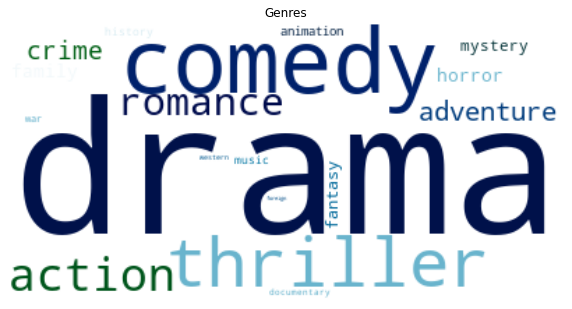

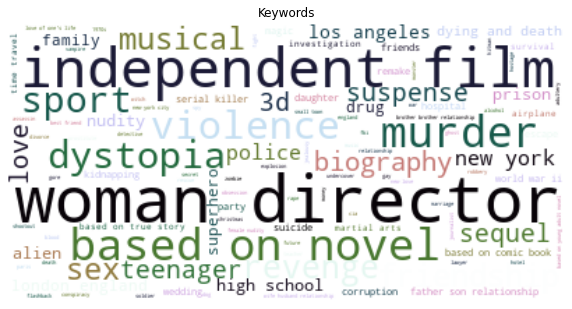

In [84]:
custom_stopwords = []
MakeWordCloud(genres_df, 10, 20, 'Genres', custom_stopwords,  500, 'ocean')
MakeWordCloud(keywords_df, 10, 20, 'Keywords', custom_stopwords, 500, 'cubehelix')

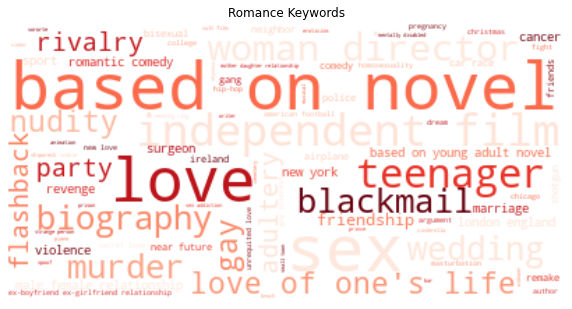

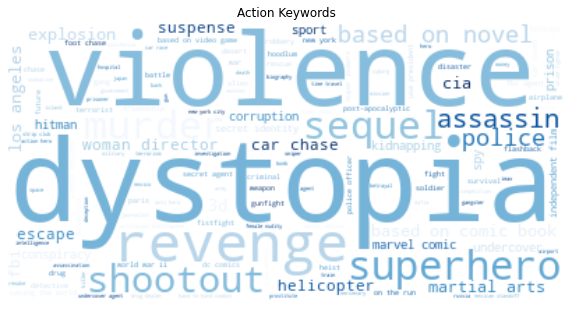

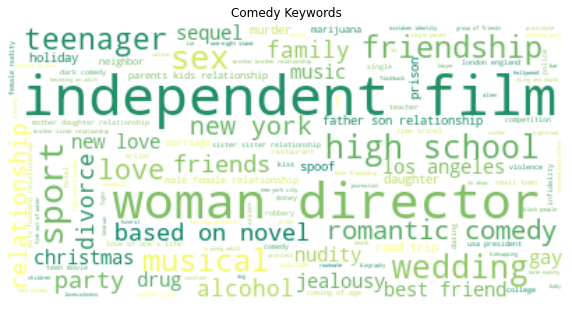

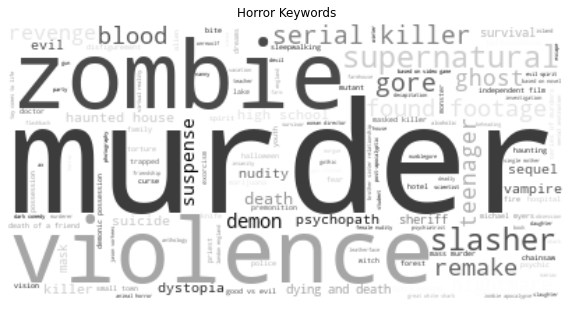

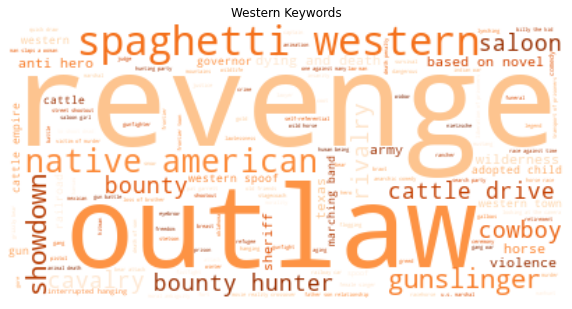

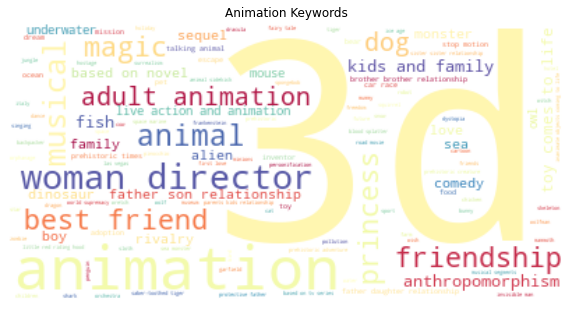

In [82]:
# Out of curiosity, let's compare the dominant keywords in the various genres
# Using genre_0, i.e. the first mentioned genre, as the "dominant genre"
def genre_wordcloud_maker(df_in, genre, color):
    MakeWordCloud(list_column_to_df(df_expanded_movies_plus_IMDB[df_expanded_movies_plus_IMDB['dominant_genre'] == genre], 'keywords'), 10, 20, 
                  genre + ' Keywords', custom_stopwords,  500, color)
    
genre_wordcloud_maker(df_expanded_movies_plus_IMDB, 'Romance', 'Reds')
genre_wordcloud_maker(df_expanded_movies_plus_IMDB, 'Action', 'Blues')
genre_wordcloud_maker(df_expanded_movies_plus_IMDB, 'Comedy', 'summer')
genre_wordcloud_maker(df_expanded_movies_plus_IMDB, 'Horror', 'gray')
genre_wordcloud_maker(df_expanded_movies_plus_IMDB, 'Western', 'Oranges')
genre_wordcloud_maker(df_expanded_movies_plus_IMDB, 'Animation', 'Spectral')    

In [45]:
# Now for a histogram view of the distribution of genres and keywords
fig = px.histogram(genres_df, x='genres', y='count', title='Distribution of Genres - Multiple Genres / movie allowed')
fig.update_layout(yaxis_title='Count', xaxis_title = 'Genres')
fig.show()

In [46]:
# And keyword histogram
fig = px.histogram(keywords_df.head(100), x='keywords', y='count', title='Top 100 Keywords - Multiple keywords / movie allowed')
fig.update_layout(yaxis_title='Count', xaxis_title = 'Keywords')
fig.show()

## Data visualization - Quantitative data
Next, let's visualize some of the quanititative and commercial components over time and by correlation.

In [47]:
# Since we will be using revenue a lot later, I will prune out movies with zero revenue or implausibly low revenue. 
# Remove low-ball budget and revenue numbers
df_expanded_movies_plus_IMDB = df_expanded_movies_plus_IMDB[df_expanded_movies_plus_IMDB['revenue']>= revenue_lower_limit]

In [88]:
# What's the number of movies vs. revenue by year?
d1 = df_expanded_movies_plus_IMDB['title_year'].value_counts().sort_index()
d2 = df_expanded_movies_plus_IMDB.groupby(['title_year'])['revenue'].mean()
data = [go.Scatter(x=d1.index, y=d1.values, name='Number of movies'), go.Scatter(x=d2.index, y=d2.values, name='Revenue', yaxis='y2')]
layout = go.Layout(
                  
                  dict(title = "Number of movies and average revenue per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  yaxis2=dict(title='Average revenue', overlaying='y', side='bottom')
                  ),
                   autosize = True,
                   width=800,
                   height = 300,
                   legend=dict(orientation="v")
                  )
py.iplot(dict(data=data, layout=layout))


Text(0.5, 1.0, 'Correlation between quantitative numerical features')

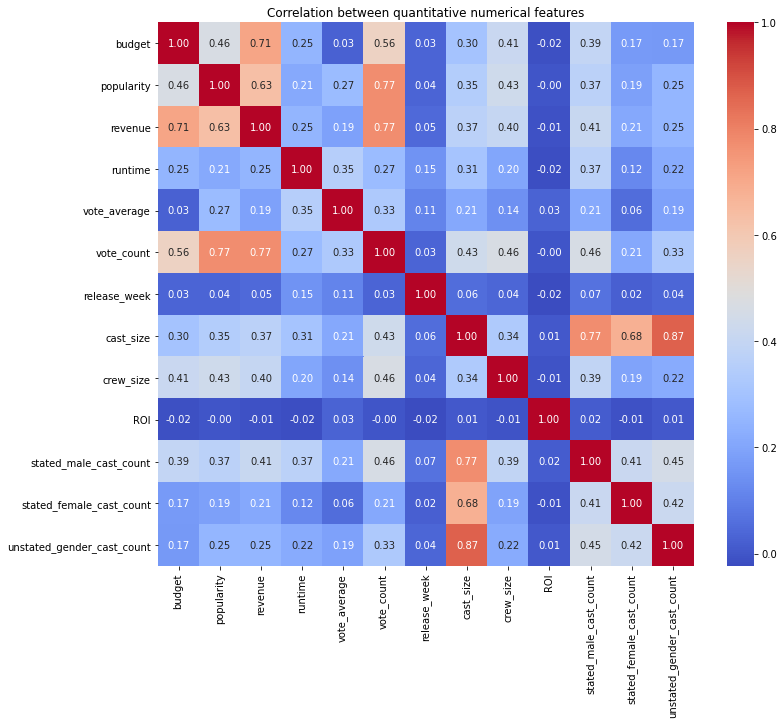

In [49]:
# Inspect correlations to see if there are any suprises
corr = df_expanded_movies_plus_IMDB[['budget', 'popularity', 'revenue', 'runtime','vote_average', 'vote_count', 'release_week', 
                                     'cast_size','crew_size','ROI','stated_male_cast_count', 'stated_female_cast_count','unstated_gender_cast_count']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr,  annot=True, 
            fmt=".2f", 
            cmap='coolwarm')
plt.title("Correlation between quantitative numerical features")


Text(0, 0.5, 'Revenue')

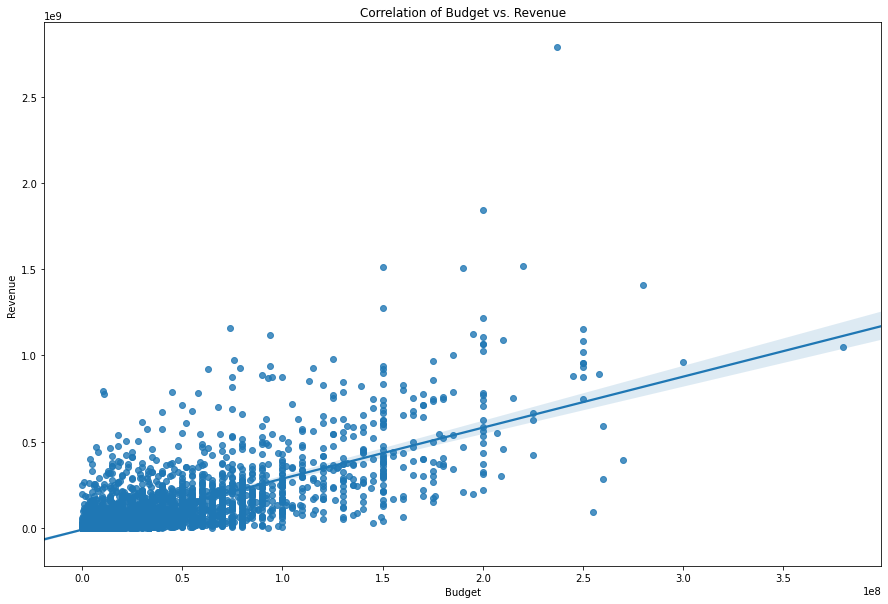

In [89]:
# Let's dive a bit into some of these correlations
# budget and revenue are more strongly correlated
plt.figure(figsize=(15, 10))
sns.regplot(x="budget", y="revenue", data = df_expanded_movies_plus_IMDB)
plt.title('Correlation of Budget vs. Revenue')
# Set x-axis label
plt.xlabel('Budget')
# Set y-axis label
plt.ylabel('Revenue')

Text(0, 0.5, 'Revenue')

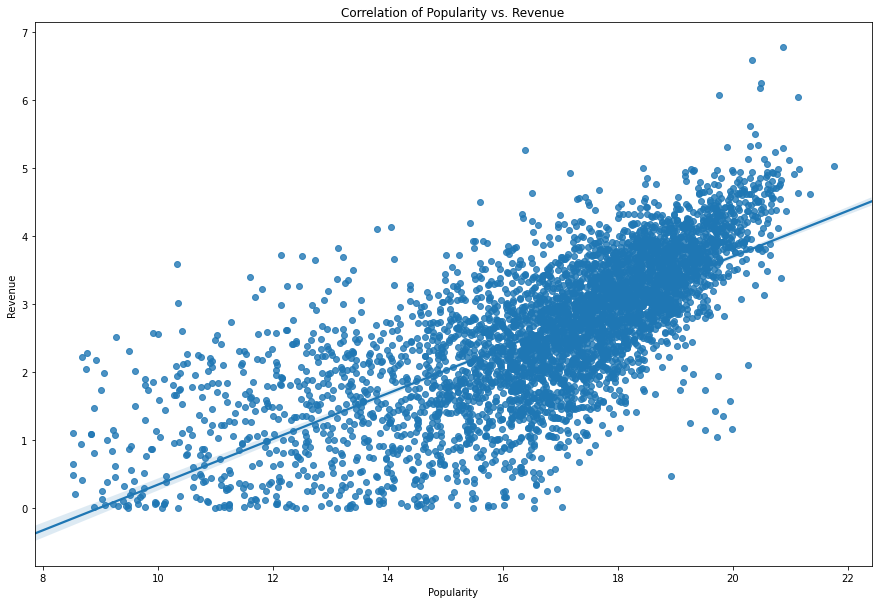

In [90]:
# Unsurprisingly, revenue and popularity also correlate. Given the wildly different scales, apply log1p transformation
# before visualizing
plt.figure(figsize=(15, 10))
df_revenue_popularity = pd.DataFrame(columns = ['revenue', 'popularity']) 
df_revenue_popularity['revenue'] = np.log1p(df_expanded_movies_plus_IMDB['revenue'])
df_revenue_popularity['popularity'] = np.log1p(df_expanded_movies_plus_IMDB['popularity'])
sns.regplot(x="revenue", y="popularity", data = df_revenue_popularity)
plt.title('Correlation of Popularity vs. Revenue')
# Set x-axis label
plt.xlabel('Popularity')
# Set y-axis label
plt.ylabel('Revenue')

Text(0, 0.5, 'Movie count')

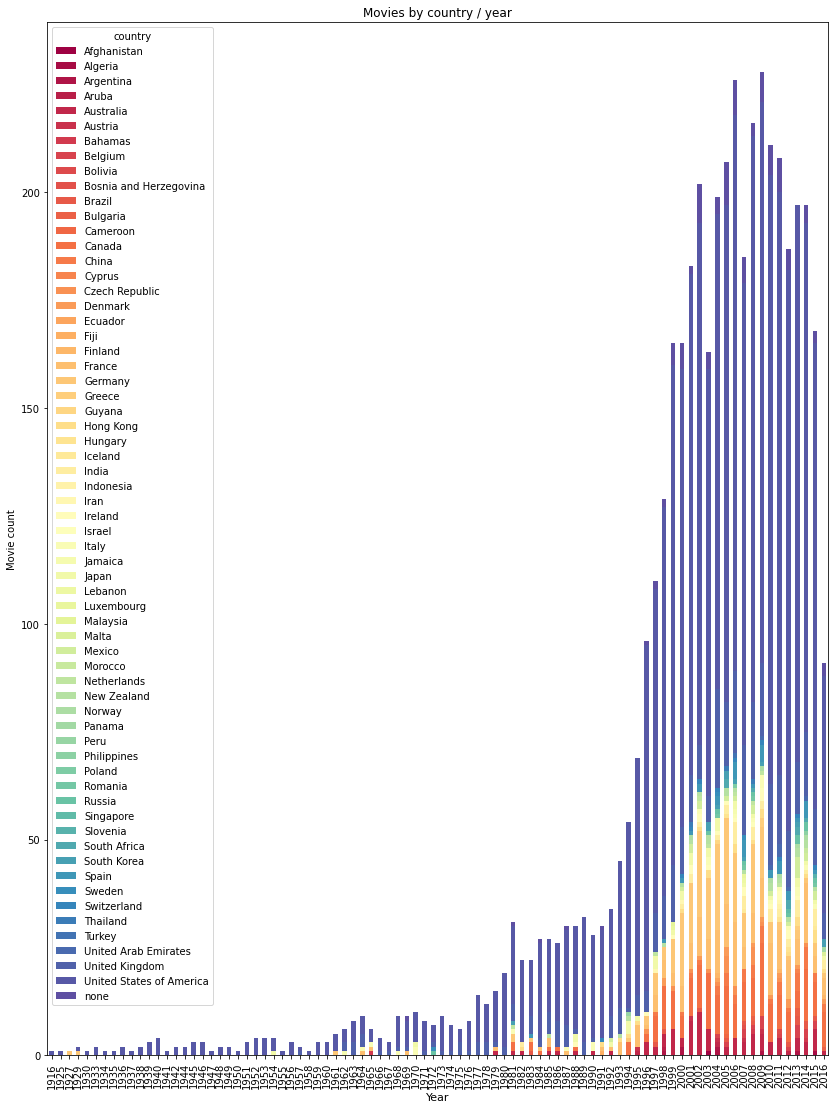

In [52]:
# Let's also inspect the movie/country distribution
plt.rcParams["figure.figsize"] = [14, 19]
movies_by_country_by_year = df_expanded_movies_plus_IMDB.groupby(["title_year", "country"]).count()['original_title'].unstack()
movies_by_country_by_year.plot(kind='bar', stacked=True, colormap='Spectral')
plt.title("Movies by country / year")
plt.xlabel("Year", fontsize=11)
plt.ylabel("Movie count")

Predictably, the US turns into the 800 lb gorilla in the 1970s. Editorial note: I thought that the 'spectral' colormap was best suited to highlight the dominance of the US vs. movie production in other countries. 

Let's take a closer look at genres for movies.

In [53]:
fig = px.pie(genres_df, values='count', names='genres', title='Relative Distribution of Genres - Global')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

 Over times, are there genres that are more popular?

Text(0, 0.5, 'Movie count')

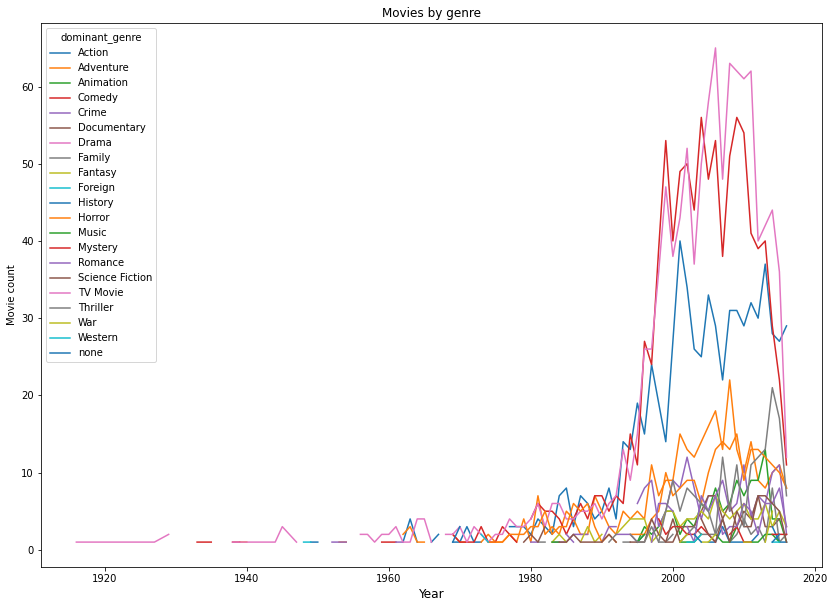

In [54]:
plt.rcParams["figure.figsize"] = [14,10]
movies_by_genre_df = df_expanded_movies_plus_IMDB.groupby(["title_year", "dominant_genre"]).count()['original_title'].unstack()
movies_by_genre_df.plot(kind='line')
plt.title("Movies by genre")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Movie count")


A little bit tough to read...action, comedy, drama are popular throughout...with an interesting emergence and the waning of musical films in the early 2000s, peaking around 2013 and then receding in importance.

Last, but not least, let's investigate the 'commercial leaders'...which directors are the most prolific with commensurate commercial results?

In [55]:
# Create aggregations for groupby() operation below
aggregations = {
    'original_title':'count',
    'revenue': 'sum'
     }
movies_by_director_df = df_expanded_movies_plus_IMDB.groupby('director_name').agg(aggregations).sort_values(by='revenue', ascending=False).reset_index()
fig = px.scatter(movies_by_director_df.head(30), x="original_title", y="revenue", size='revenue', text = 'director_name',
                labels={
                     "original_title": "Number of movies",
                     "revenue": "Aggregate Revenue" 
                 },
                title="Revenue & number of movies for Top 30 Directors")
                
fig.show()


The usual suspects among the commercial leaders among directors. Let's repeat for actors

In [56]:
# A little bit more challenging, as there are several actors to choose from per movie.
# Let's iterate through all movies and create a list of all available actors

all_actors = []
for actor_list in df_expanded_movies_plus_IMDB['cast']:
    for actor_item in actor_list:
        all_actors.append(actor_item.name)
        
# Create set to remove dupes and convert to dictionary to hold our values
revenue_dict = dict.fromkeys(set(all_actors), [0,0]) 

# Now iterate through rows of full dataframe
for index, row in df_expanded_movies_plus_IMDB.iterrows():
    # Create row-specific variables
    movie_revenue = row['revenue']
    # Iterate through whole cast
    for actor in row['cast']:
        # Get name of individual actor in cast
        key = str(actor.name)
        # Make sure that actor is in dictionary...should always be true, but just in case
        if key !='nan':
            # Update dictionary entry for that actor
            current_entry = revenue_dict[key]
            current_revenue = current_entry[0]
            current_movie_count = current_entry[1]
            revenue_dict[key] =  [int(current_revenue)+int(movie_revenue),int(current_movie_count) +1]

# Create dataframe from dictionary            
all_actors_revenue_df = pd.DataFrame.from_dict(revenue_dict, orient='index').reset_index()
# Rename columns
all_actors_revenue_df.columns = ['actor', 'cumulative_revenue','movie_count']
# Sort by revenue
all_actors_revenue_df=all_actors_revenue_df.sort_values(by=['cumulative_revenue'], ascending=False)
# Visualize top 30 actors by revenue regardless of lead/supporting actor
fig = px.scatter(all_actors_revenue_df.head(30), x="movie_count", y="cumulative_revenue", size='cumulative_revenue', text = 'actor',
                labels={
                     "movie_count": "Number of movies",
                     "cumulative_revenue": "Aggregate Revenue" 
                 },
                title="Revenue & number of movies for Top 30 Actors - As lead or supporting cast")
                
fig.show()
            

Samuel L. Jackson is box office gold, no doubt. But in this view, his standing is greatly boosted by his prolific career and participation in the hit Avengers / Marvel movies as part of a larger ensemble cast. 

Another interesting outlier is Stan Lee whose many cameos in hugely popular movies create a somewhat distorted picture of box-office impact.

Let's zoom in on leading actors only, i.e. the actors who received 'top billing' in a movie's cast.

In [57]:
# Re-initializing revenue dictionary
revenue_dict_top_billed_actors = dict.fromkeys(set(all_actors), [0,0]) 
# Iterate full dataframe
for index, row in df_expanded_movies_plus_IMDB.iterrows():
    # Iterate through cast
    if len(row['cast'])>0:
        movie_revenue = row['revenue']
        # Take only top-billed actor
        key = row['cast'][0].name
        # Update dict entry
        current_entry = revenue_dict_top_billed_actors[key]
        current_revenue = current_entry[0]
        current_movie_count = current_entry[1]
        revenue_dict_top_billed_actors[key] =  [int(current_revenue)+int(movie_revenue),int(current_movie_count) +1]

# Convert dict to dataframe
top_billed_actors_revenue_df = pd.DataFrame.from_dict(revenue_dict_top_billed_actors, orient='index').reset_index()
# Rename columns
top_billed_actors_revenue_df.columns = ['actor', 'cumulative_revenue','movie_count']
# Sort by revenue
top_billed_actors_revenue_df=top_billed_actors_revenue_df.sort_values(by=['cumulative_revenue'], ascending=False)
# Take top 30 top-billed actors and visualize
fig = px.scatter(top_billed_actors_revenue_df.head(30), x="movie_count", y="cumulative_revenue", size='cumulative_revenue', text = 'actor',
                labels={
                     "movie_count": "Number of movies",
                     "cumulative_revenue": "Aggregate Revenue" 
                 },
                title="Revenue & number of movies for Top 30 Leading Actors")
                
fig.show()

OK, this picture seems to be more sense, with highly recognizable "marquee" names towards the top right and no 'cameo' or supporting cast outliers. 

# Modeling - Revenue prediction via Machine Learning

Time to create a train a model and see if we can predict movies based on actors, director, budget, keywords and description. 

## Data preprocessing

To get our data ready for machine learning, we'll
- drop unnecessary columns
- use a custom one-hot encoder to vectorize columns with consideration of revenue correlation of the feature
- create vectorizable representations of categorical variables and free-form text using a pipeline and onehot/TFIDF

As I have a grab-bag of numerical and categorical features, I will use the ColumnTransformer from sklearn 2.0+ and compose various transformers into a pipeline. Note: Technically, the LGBMRegressor can handle categorical features natively, but I chose to one-hot encode those anyway to increase model portability.


In [58]:
# Drop columns that will be disregarded for the machine learning exercise
df = df_expanded_movies_plus_IMDB.drop(['homepage','id', 'original_title', 'title', 'tagline','production_companies', 
                                        'status','spoken_languages', 'production_countries', 'release_date', 'dominant_genre', 
                                        'crew'], axis=1)

In [59]:
# Get target and features
target =df['revenue']
features = df.drop('revenue', axis=1)
# Convenience sub-frames and list for later use
categorical_features_df = features.loc[:,features.dtypes==np.object]
numeric_features_df = features.drop(categorical_features_df.columns, axis=1)
numeric_features = list(numeric_features_df.columns)

In [60]:
# Custom one hot encoder.
def custom_one_hot_encoder(dfIn, dfInColumnToParse, dfControl, intControlSubset, dfControlColumn, dfOutColumnPrefix):
    '''
    INPUTS:
    df_in              -  dataframe containing one-hot-encodable column
    dfInColumnToParse  -  column to one-hot encode
    dfControl          -  dataframe containing reference set, e.g. top-grossing actors
    intControlSubset   -  clip level, e.g. how many of the top actors should we consider? Top 50? Top 200?
    dfControlColumn    -  column containing entries we are looking for, e.g. actor names
    dfOutColumnPrefix  -  column prefix for the one-hot encoded output columns

    OUTPUTS:
    df_in              -  one-hot encoded dataframe
    '''
    # The list with entries I am interested in, e.g. the top 200 directors or actors by revenue
    control_list = list(dfControl.head(intControlSubset)[dfControlColumn])
    # Iterate through the dataframe
    for index, row in dfIn.iterrows():
        # See if the target column we want to one-hot encode is a list or a string.
        # Actors will be lists, directors will be strings. 
        if type(row[dfInColumnToParse]) is list:
            # If there are items to encode get their string representation...
            if len(row[dfInColumnToParse]) > 0:
                for item in row[dfInColumnToParse]:
                    if type(item) is cast_member:
                        strCandidate = item.name
                    else:
                        strCandidate = item
                    # ... and create a new column for them with the right prefix and label    
                    if strCandidate in control_list:
                        col = dfOutColumnPrefix + strCandidate.replace(' ','')
                        dfIn.at[index,col] = 1
        else:
            # We just have a string to convert
            if row[dfInColumnToParse] !='nan':
                strCandidate = row[dfInColumnToParse]
                # Make sure they are 'on the list'
                if strCandidate in control_list:
                    col = dfOutColumnPrefix + strCandidate.replace(' ','')
                    dfIn.at[index,col] = 1

    # Remove the column we just expanded into many columns   
    dfIn = dfIn.drop(dfInColumnToParse, axis=1)
    return dfIn

In [61]:
def custom_one_hot_features(dfIn):
    '''
    INPUTS:
    df_in              -  dataframe containing features to be one-hot encoded

    OUTPUTS:
    df_in              -  one-hot encoded dataframe
    '''
    # Grouping all one-hot encoding steps into one callable function for convenience
    dfIn = custom_one_hot_encoder(dfIn, 'cast', top_billed_actors_revenue_df, 200, 'actor', 'top_actor_')
    dfIn = custom_one_hot_encoder(dfIn, 'genres',  genres_df, 20, 'genres', 'genre_')
    dfIn = custom_one_hot_encoder(dfIn, 'director_name',  movies_by_director_df, 200, 'director_name','top_director_')
    dfIn = custom_one_hot_encoder(dfIn, 'keywords', keywords_df, 500, 'keywords', 'keyword_')
    return dfIn

In [62]:
# Perform custom one-hot encoding on features dataframe
features =  custom_one_hot_features(features)

## Initial Model Implementation

In [63]:
# Add remaining one-hot encodable features to a list
one_hot_list = ['original_language','country']
# Create pipeline
one_hot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), #Shouldn't be necessary, but including just in case
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [64]:
# Configure column transformer
# Consists of standard one-hot pipeline from above, log1p transformer for numeric features and TFIDF vectorizer

# Tell TFIDF how many columns we want back
max_feat = 500
preprocessor = ColumnTransformer(
    transformers=[
        ('log', FunctionTransformer(np.log1p, validate=False), numeric_features),
        ('one_hot', one_hot_transformer, one_hot_list),
        ('overview_tfidf', TfidfVectorizer(max_features = max_feat, stop_words = 'english', ngram_range=(1,2)), 'overview')
       ],
       remainder='passthrough')

In [65]:
# Configure LGBMRegressor
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l2', 'auc'],
    'learning_rate': 0.05,
    'is_training_metric': True,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': -1,
    "max_depth": 8,
    "num_leaves": 256,  
    "max_bin": 256,
    "n_estimators": 100    
}
gbm = lgb.LGBMRegressor(**hyper_params, verbose_eval = False)

In [66]:
# Complete the pipeline, including transformers and estimator
model = make_pipeline(
    preprocessor,
    gbm
    )

# Scaling the target variable is very, very important in this case as the range goes from $5,000 to $2.7B
# Without scaling the target variable, the R2 score is about 0.006 (!!)
wrapped_model = TransformedTargetRegressor(regressor=model, transformer=StandardScaler())

In [67]:
# Split data into train / test set
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=44, shuffle = True)

In [68]:
# Cross-validation to explore portability of model 
kfold = KFold(n_splits=3, shuffle=True, random_state=21)
cv_results = cross_val_score(wrapped_model, X_train, y_train, cv=kfold, scoring='r2')

In [69]:
# Explore results...looking good!
cv_results

array([0.92212589, 0.85821343, 0.92569477])

In [70]:
# Train the model and print score
wrapped_model = wrapped_model.fit(X_train, y_train);

In [71]:
print("Gradient Boosting Machine R2 Score: %f" % wrapped_model.score(X_test, y_test))

Gradient Boosting Machine R2 Score: 0.942925


Promising results and entirely in line with the CV pass.

Gradient Boosting Machine RMSLE Score: 1.379354


Text(0, 0.5, 'Predicted Revenue')

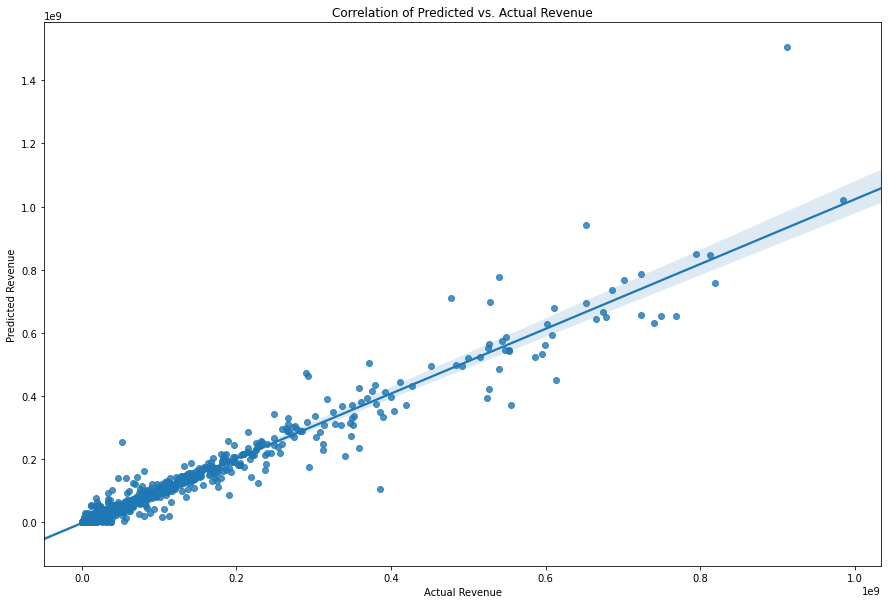

In [72]:
y_true = list(y_test)
y_pred = list(wrapped_model.predict(X_test))
pred_df = pd.DataFrame(np.column_stack([y_true, y_pred]), 
                               columns=['true', 'pred'])
pred_df['title'] = df_expanded_movies_plus_IMDB['title']
pred_df['year'] = df_expanded_movies_plus_IMDB['title_year']
pred_df['amount_delta'] = pred_df.pred - pred_df.true
pred_df['percent_delta']= pred_df.amount_delta / (pred_df.true)

# Drop negative value rows
pred_df_clean = pred_df[pred_df['pred']>0]
print("Gradient Boosting Machine RMSLE Score: %f" % np.sqrt(mean_squared_log_error(pred_df_clean.true, pred_df_clean.pred)))

plt.figure(figsize=(15, 10))
sns.regplot(x="pred", y="true", data = pred_df_clean)

plt.title('Correlation of Predicted vs. Actual Revenue')
# Set x-axis label
plt.xlabel('Actual Revenue')
# Set y-axis label
plt.ylabel('Predicted Revenue')

## Model refinement and optimization

Next stop: hyperparameter tuning!

In [73]:
wrapped_model.get_params()

{'check_inverse': True,
 'func': None,
 'inverse_func': None,
 'regressor__memory': None,
 'regressor__steps': [('columntransformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('log',
                                    FunctionTransformer(func=<ufunc 'log1p'>),
                                    ['budget', 'popularity', 'runtime',
                                     'vote_average', 'vote_count', 'title_year',
                                     'release_week', 'cast_size', 'crew_size',
                                     'number_production_companies', 'ROI',
                                     'director_count', 'writer_count',
                                     'editor_count', 'sound_department_size',
                                     'costume_department_size',...
                                     'stated_male_cast_count',
                                     'stated_female_cast_count',
                                     'unstated_

In [74]:
# Create a Bayesian CV tuner with parameter ranges
bayes_cv_tuner = BayesSearchCV(
        estimator = wrapped_model,
        search_spaces = {
            'regressor__columntransformer__overview_tfidf__max_features':(500, 1000, 5000),
            'regressor__lgbmregressor__learning_rate': (0.001, 0.05, 0.1), 
            'regressor__lgbmregressor__feature_fraction': (0.1, 0.5, 0.9),
            'regressor__lgbmregressor__max_depth': (8, 16, 32),
            'regressor__lgbmregressor__num_leaves': (32, 64, 128, 256),  
            'regressor__lgbmregressor__max_bin': (32, 64, 256),
            'regressor__lgbmregressor__n_estimators': (100, 256, 1024, 5000, 10000),    
            'regressor__lgbmregressor__bagging_fraction': (0.5, 0.7, 0.9),    
            'regressor__lgbmregressor__bagging_freq': (5, 10, 20, 100)    
        },
        cv = kfold,
        scoring = 'r2',
        n_jobs = 4,
        n_iter = 12,
        verbose=2,
        refit = True,
        random_state = 42
        )

In [75]:
# Run Bayesian tuner
result = bayes_cv_tuner.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  1.7min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:   13.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  2.0min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  2.1min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  1.6min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:   28.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:   32.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    7.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    8.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:   11.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  1.9min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    7.5s finished


In [76]:
# Get best parameters
print(result.best_params_)

OrderedDict([('regressor__columntransformer__overview_tfidf__max_features', 1000), ('regressor__lgbmregressor__bagging_fraction', 0.9), ('regressor__lgbmregressor__bagging_freq', 10), ('regressor__lgbmregressor__feature_fraction', 0.9), ('regressor__lgbmregressor__learning_rate', 0.05), ('regressor__lgbmregressor__max_bin', 64), ('regressor__lgbmregressor__max_depth', 16), ('regressor__lgbmregressor__n_estimators', 1024), ('regressor__lgbmregressor__num_leaves', 128)])


In [77]:
# Use optimal parameters to configure and retrain 
# Tell TFIDF how many columns we want back
max_feat = 1000
preprocessor = ColumnTransformer(
    transformers=[
        ('log', FunctionTransformer(np.log1p, validate=False), numeric_features),
        ('one_hot', one_hot_transformer, one_hot_list),
        ('overview_tfidf', TfidfVectorizer(max_features = max_feat, stop_words = 'english', ngram_range=(1,2)), 'overview')
       ],
       remainder='passthrough')


hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l2', 'auc'],
    'learning_rate': 0.05,
    'is_training_metric': True,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 10,
    'verbose': -1,
    "max_depth": 16,
    "num_leaves": 128,  
    "max_bin": 64,
    "n_estimators": 1024    
}
gbm = lgb.LGBMRegressor(**hyper_params, verbose_eval = False)

In [78]:
# Recreating the model pipeline
model_optimized = make_pipeline(
    preprocessor,
    gbm
    )

# Wrapping new model 
wrapped_model_optimized = TransformedTargetRegressor(regressor=model_optimized, transformer=StandardScaler())

In [79]:
wrapped_model_optimized = wrapped_model_optimized.fit(X_train, y_train)

In [80]:
print("Gradient Boosting Machine Score after Bayesian Optimization: %f" % wrapped_model_optimized.score(X_test, y_test))

Gradient Boosting Machine Score after Bayesian Optimization: 0.949329


Gradient Boosting Machine RMSLE Score: 1.301460


Text(0, 0.5, 'Predicted Revenue')

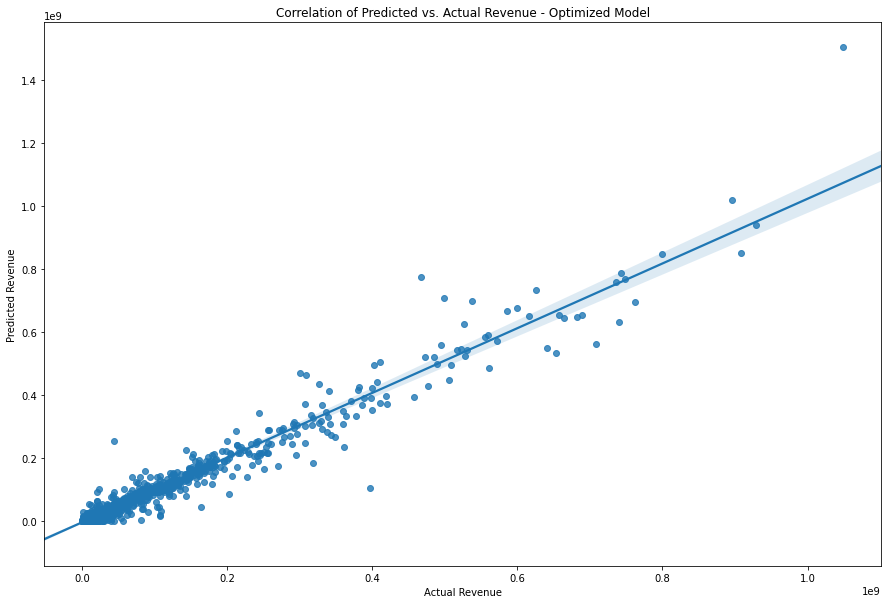

In [97]:
y_true = list(y_test)
y_pred = list(wrapped_model_optimized.predict(X_test))
pred_df = pd.DataFrame(np.column_stack([y_true, y_pred]), 
                               columns=['true', 'pred'])
pred_df['title'] = df_expanded_movies_plus_IMDB['title']
pred_df['year'] = df_expanded_movies_plus_IMDB['title_year']
pred_df['amount_delta'] = pred_df.pred - pred_df.true
pred_df['percent_delta']= pred_df.amount_delta / (pred_df.true)

# Drop negative value rows
pred_df_clean = pred_df[pred_df['pred']>0]
print("Gradient Boosting Machine RMSLE Score: %f" % np.sqrt(mean_squared_log_error(pred_df_clean.true, pred_df_clean.pred)))

plt.figure(figsize=(15, 10))
sns.regplot(x="pred", y="true", data = pred_df_clean)

plt.title('Correlation of Predicted vs. Actual Revenue - Optimized Model')
# Set x-axis label
plt.xlabel('Actual Revenue')
# Set y-axis label
plt.ylabel('Predicted Revenue')

A slight improvement as can be expected from an initial hyperparameter tuning pass. 

# Results and discussion

The goal of this project was to determine whether historical movie data can be used to predict revenue on a test set or for future movies. I believe that given the high R2 score, there is a definitive role for machine learning as **one of many** inputs into the decision pipeline for studio executives. 

Naturally,  there are also many intangibles that contribute to the box office success of an individual release that cannot be captured adequately by pure data including on-screen chemistry of the lead actors, the competitive release schedule of other studios, external disruptions (e.g. the current Covid-19 pandemic), weather, etc.

## Challenges

### Data quality
The source data set of approximately 5,000 movies was missing close to 30% of revenue figures and 20% of budget figures. As the dataset was also lacking an unambiguous URL-resolvable way of looking up the missing values, I created a 'screen-scraping' workaround using a URL-encoded search against the IMDB.com site (starting with the movie title and release year) and subsequently parsing the HTML results for budget and revenue data. 

### Data format and feature variety
The original data set contained JSON encoded objects mixed in with strings, floats and integers that required extensive pre-processing to create more convenient representations, especially of the JSON objects. In addition, there were natural-language features that required vectorization to become useable in a regression model (TFIDF Vectorizer was chosen in this notebook).

### Feature scale
The target feature of 'revenue' ranges from a few thousand dollars to 2.7B dollars. Similarly, the 'budget' feature ranges from several thousand to several hundred million dollars. This required rescaling of both features and target data points. In an initial attempt (before re-scaling the target variable), I achieved a measly R2 score of only 0.006 given the huge distribution of revenue.

### One-hot encoding of cast and crew based on revenue relevance
Traditional one-hot encoding would have a) resulted in a huge, extremely sparse matrix of thousands of actors and directors and b) not necessarily provided actors that are more strongly correlated to box-office success. I decided to create my own one-hot encoder that could take a 'control dataframe' as an additional input and only one-hot encode actors and directors high on the 'commercial impact scale', i.e. individuals with proven box-office success. 


## Improvements
There are numerous potential improvements

### Experiment with model alternatives, score alternatives and more extensive hyperparameter tuning
Additional model architectures could be evaluated to see if e.g. XGB results in superior performance. The selected model could also be more extensively tuned across a wider hyperparameter search space. In addition, we should consider other potential quality metrics of the regression outcomes like RMSE, RMSLE, etc.

### Additional data augmentation and changes to imputation mechanisms
Additional manual lookups or alternative automated screen-scraping attempts can be made to complete the remaining budget and revenue gaps in the data set. A machine learning approach could also be taken to impute any remaining gaps (vs. the simplistic 'mean()' approach chosen above).

### Perform additional feature engineering 
Additional polynomial features could be generated to unearth other revenue-relevant aspects of the composition of cast & crew, seasonality of release date, etc.

### Improve NLP processing
The current transformation using a single TFIDF vectorizer could be enhanced with additional steps including more sophisticated lemmatization, part-of-speech selection, and other steps. 

